In [5]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(random_state = 1)
model2 = QuadraticDiscriminantAnalysis()
model3 = GaussianNB()

from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

ensemble = VotingClassifier(estimators=[('lr',model1),('qda',model2),('gnb',model3)])
ens_model = ensemble.fit(X,y)

y_pred = ens_model.predict(X)

from sklearn.model_selection import cross_val_score, KFold

cv = KFold(5, shuffle=True, random_state= 0)
check = cross_val_score(ens_model, X,y, scoring = "accuracy", cv=cv).mean()
check

0.96

In [2]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

model1 = DecisionTreeClassifier(max_depth=10)
model2 = BaggingClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=100)
accuracy1 = cross_val_score(model1, X,y, scoring= "accuracy", cv = cv)
accuracy2 = cross_val_score(model2, X, y, scoring = "accuracy", cv=cv)
accuracy1.mean(), accuracy1.std(), accuracy2.mean(), accuracy2.std()

(0.9533333333333334, 0.039999999999999994, 0.96, 0.053333333333333316)

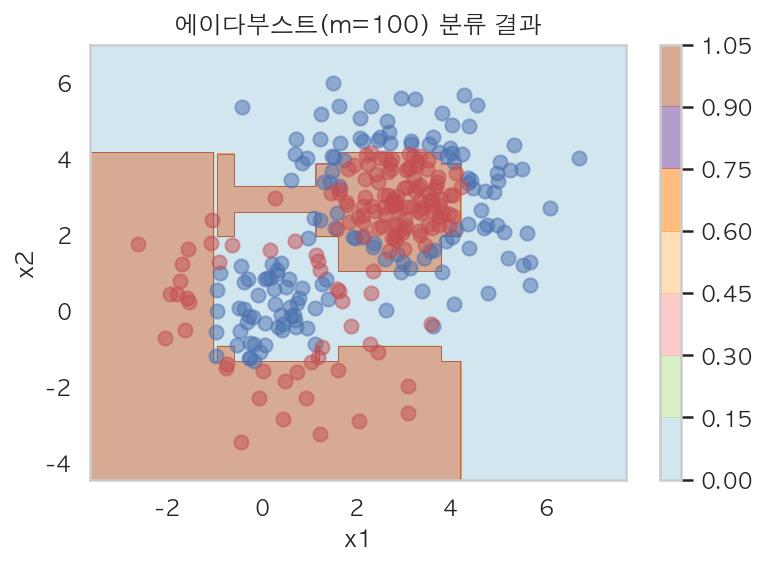

In [7]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=100, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

class MyAdaBoostClassifier(AdaBoostClassifier):
    
    def __init__(self,
                 base_estimator=None,
                 n_estimators=50,
                 learning_rate=1.,
                 algorithm='SAMME.R',
                 random_state=None):

        super(MyAdaBoostClassifier, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state)
        self.sample_weight = [None] * n_estimators
        
    def _boost(self, iboost, X, y, sample_weight, random_state):
        sample_weight, estimator_weight, estimator_error = \
        super(MyAdaBoostClassifier, self)._boost(iboost, X, y, sample_weight, random_state)
        self.sample_weight[iboost] = sample_weight.copy()
        return sample_weight, estimator_weight, estimator_error
    
model_ada = MyAdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0), n_estimators=20)
model_ada.fit(X, y)

def plot_result(model, title="분류결과", legend=False, s=50):
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02), np.arange(x2_min, x2_max, 0.02))
    if isinstance(model, list):
        Y = model[0].predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
        for i in range(len(model) - 1):
            Y += model[i + 1].predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    else:
        Y = model.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, Y, cmap=plt.cm.Paired, alpha=0.5)
    for i, n, c in zip(range(2), "01", "br"):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=c, s=s, alpha=0.5, label="Class %s" % n)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.colorbar(cs)
    if legend:
        plt.legend()
    plt.grid(False)

plot_result(model_ada, "에이다부스트(m=100) 분류 결과")

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

model_grad = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=0)

In [9]:
%%time
model_grad.fit(X, y)

CPU times: user 54.3 ms, sys: 1.41 ms, total: 55.7 ms
Wall time: 55.1 ms


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

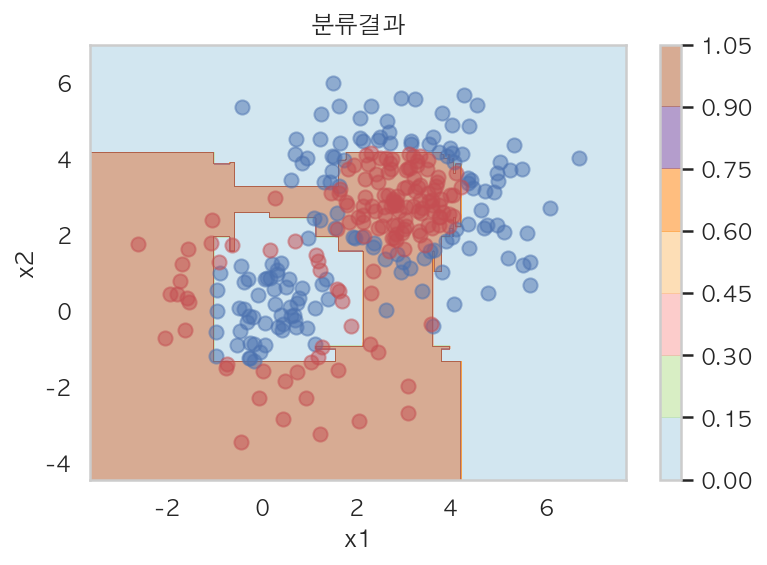

In [10]:
plot_result(model_grad)